#### Metode i primjena vjestacke inteligencije
#### Laboratorijska vjezba 8
#### Student: Masovic Haris
#### Index: 1689/17993

## 0. Dependencies

In [ ]:
import sys
from google.colab import drive 

drive.mount('/content/gdrive')

!{sys.executable} -m pip install matplotlib Image

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## 2. Ekstrakcija znacajki

### 2.1 Ucitavanje modela

In [ ]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

#### 2.1.2 Koristenjem naredbe `conv base.summary()` isprintajte informacije o modelu. Objasnite strukturu modela, tj. vrste nivoa koji se koriste i kako izbor nivoa utice na izlaze iz svakog nivoa.

- Na osnovu prikazanih informacija summary-a ispod, moze se vidjeti da se koriste sljedeci slojevi u modelu: `InputLayer`, `Conv2D`, `MaxPooling2D`.
- Izbor sloja utice na izlaz iz svakog nivoa jer zavisno od parametara specificiranih u definicijni svakog sloja, desavaju se promjene nad dimenzijama slike, kao i o promjenama "dubine" informacija o znacajkama.
- Polazni oblik znacajki je `(150, 150, 3)`, dok je finalni oblik nakon svih slojeva `(4, 4, 512)`.

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

#### 2.1.4 Koji je oblik krajnje (izlazne) mape znacajki?

- Oblik krajnje mape znacajki je `(4, 4, 512)`.

### 2.2 Brza ekstrakcija bez povecanja podataka (Prva tehnika)

In [ ]:
% tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np

base_dir = '/content/gdrive/MyDrive/Colab Notebooks/downsized/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory, target_size=(150, 150), batch_size=batch_size, class_mode='binary')
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must ‘break‘ after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1005 images belonging to 2 classes.


#### 2.2.2 Koji su oblici izlaznih varijabli (ukupno 6 varijabli), koju vrsta podataka koriste i koliko memorije zauzimaju?

In [ ]:
def print_data_info(name, dataset):
    print(*[name, 'je tipa:', dataset.dtype, 'ima oblik:', dataset.shape, 'a zauzima:', dataset.nbytes, 'bajta memorije.'])
    print('')
    
print_data_info('train_features', train_features)
print_data_info('validation_features', validation_features)
print_data_info('test_features', test_features)

train_features je tipa: float64 ima oblik: (2000, 4, 4, 512) a zauzima: 131072000 bajta memorije.

validation_features je tipa: float64 ima oblik: (1000, 4, 4, 512) a zauzima: 65536000 bajta memorije.

test_features je tipa: float64 ima oblik: (1000, 4, 4, 512) a zauzima: 65536000 bajta memorije.



#### 2.2.3 Posto `Dense()` nivo ocekuje 1D podatke, potrebno je nizove znacajki (ne odnosi se na oznake/labele) pretvoriti u 1D niz (reshape).

In [ ]:
import numpy as np

train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

#### 2.2.4 Obzirom da ekstrakcija znacajki traje znacajno dugo, te je nepotrebno pokretati ekstrakciju vise od jedan put, potrebno je ukljuciti `savetxt` iz numpy paketa i sacuvati sve znacajke i njihove labele u csv datoteke (njih 6). Napisite kod koji omogucava spasavanje sadrzaja zadnjih 6 varijabli na drive.

In [ ]:
import numpy as np

# change 4 user pref
local_csv_uri = '/content/gdrive/MyDrive/Colab Notebooks/csv'

def save_data_to_csv(name, dataset):
    np.savetxt('{0}/{1}.csv'.format(local_csv_uri, name), dataset, delimiter=',')

def load_data_from_csv(name):
    return np.loadtxt('{0}/{1}.csv'.format(local_csv_uri, name), delimiter=',')


save_data_to_csv('train_features', train_features)
save_data_to_csv('validation_features', validation_features)
save_data_to_csv('test_features', test_features)

save_data_to_csv('train_labels', train_labels)
save_data_to_csv('validation_labels', validation_labels)
save_data_to_csv('test_labels', test_labels)

### 2.2.1 Definisanje novog modela

#### 2.2.1.1 Po zadatom opisu i na osnovu primjera sa prethodnih vjezbi definisite novi model (u novoj datoteci).

In [ ]:
% tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
import time

model = models.Sequential()

model.add(layers.Dense(256, activation='relu', input_dim = 4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])

#### 2.2.1.2 Podatke ucitati iz datoteka na drive-u uz pomoc `loadtxt`.

In [ ]:
train_features = load_data_from_csv('train_features')
validation_features = load_data_from_csv('validation_features')
test_features = load_data_from_csv('test_features')

train_labels = load_data_from_csv('train_labels')
validation_labels = load_data_from_csv('validation_labels')
test_labels = load_data_from_csv('test_labels')

#### 2.2.1.3 Istrenirajte model sa znacajkama koje su dobijene iz prethodne sekcije. Koliko vremenski traje treniranje?

In [ ]:
first_timestamp = time.time()

history = model.fit(train_features, train_labels, epochs=30, batch_size=20, validation_data=(validation_features, validation_labels))

second_timestamp = time.time()

training_time = second_timestamp - first_timestamp

print(*['Treniranje traje:', training_time, 'sekundi.'])

Epoch 1/30
100/100 [==============================] - 1s 5ms/step - loss: 0.6940 - acc: 0.6094 - val_loss: 0.4275 - val_acc: 0.8400
Epoch 2/30
100/100 [==============================] - 0s 4ms/step - loss: 0.4314 - acc: 0.8115 - val_loss: 0.3512 - val_acc: 0.8740
Epoch 3/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3715 - acc: 0.8307 - val_loss: 0.3157 - val_acc: 0.8840
Epoch 4/30
100/100 [==============================] - 0s 4ms/step - loss: 0.3002 - acc: 0.8840 - val_loss: 0.3322 - val_acc: 0.8510
Epoch 5/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2744 - acc: 0.8922 - val_loss: 0.2771 - val_acc: 0.8860
Epoch 6/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2646 - acc: 0.9013 - val_loss: 0.2689 - val_acc: 0.8950
Epoch 7/30
100/100 [==============================] - 0s 4ms/step - loss: 0.2556 - acc: 0.8982 - val_loss: 0.2614 - val_acc: 0.9010
Epoch 8/30
100/100 [==============================] - 0s 4ms/step - loss: 0.

#### 2.2.1.4 Graficki prikazite tacnost i funkciju gubitka na skupovima za treniranje i validaciju. Napisite kod i prokomentarisite rezultate.

- Kod je dat ispod, zajedno sa graficima.
- Vidimo da se dostize tacnost oko 90%, te da je ovaj rezultat bolji no rezultata iz prosle vjezbe.
- Takodjer vidimo iako je koristen `dropout` sloj, imamo overfitting koji nastane veoma brzo.

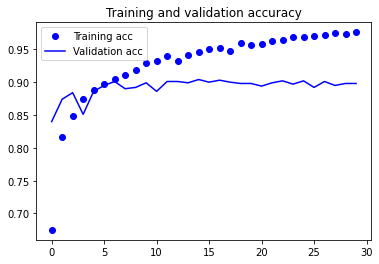

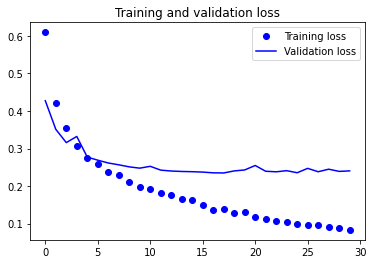

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### 2.3 Ekstrakcija sa povecanjem podataka (Druga tehnika)

In [ ]:
% tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

conv_base.trainable = False

model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])

#### 2.3.1 Isprintati `model.summary()` i objasniti strukturu mreze, kao i broj parametara.

- Vidimo da postoj istrenirani `vgg16` model i slojevi u tom modelu, postoje takodjer jedan `Flatten` sloj i dva `Dense` sloja.
- Ukupan broj parametara modela `vgg16` je `14714688`. Takodjer oblik izlaznih podataka `vgg16` iznosi `(None, 4, 4, 512)`.
- Oblik izlaznih podataka nakon `Flatten` sloja je `(None, 8192)` odnosno `(None, 4*4*512)`.
- Nakon prvog `Dense` sloja oblik podataka je `(None, 256)`, a broj parametara je: `(8192 + 1) * 256 = 2097408`.
- Nakon drugog `Dense` sloja oblik podataka je `(None, 1)`, a broj parametara je `(256 + 1) * 1 = 257`.
- Ukupan broj parametara definisanog modela je: `16812353`.

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


### 2.4 Definisanje generatora za povecanje podataka

#### 2.4.1 Dodajte kod za definisanje generatora na osnovu informacija datih u Lab 7, sekcija 4.2.

In [ ]:
% tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
import os 

base_dir = '/content/gdrive/MyDrive/Colab Notebooks/downsized/'
train_dir = os.path.join(base_dir, 'train')

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=20, class_mode='binary')
validation_generator = test_datagen.flow_from_directory(validation_dir, target_size=(150, 150), batch_size=20, class_mode='binary')

# training

first_timestamp = time.time()

history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=100, validation_data=validation_generator, validation_steps=50)

second_timestamp = time.time()

training_time = second_timestamp - first_timestamp

print(*['Treniranje traje:', training_time, 'sekundi.'])

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
100/100 [==============================] - 23s 224ms/step - loss: 0.6216 - acc: 0.6516 - val_loss: 0.4501 - val_acc: 0.8250
Epoch 2/100
100/100 [==============================] - 22s 216ms/step - loss: 0.5039 - acc: 0.7757 - val_loss: 0.3721 - val_acc: 0.8580
Epoch 3/100
100/100 [==============================] - 22s 215ms/step - loss: 0.4595 - acc: 0.7927 - val_loss: 0.3338 - val_acc: 0.8740
Epoch 4/100
100/100 [==============================] - 21s 215ms/step - loss: 0.4408 - acc: 0.7864 - val_loss: 0.3106 - val_acc: 0.8770
Epoch 5/100
100/100 [==============================] - 22s 220ms/step - loss: 0.3895 - acc: 0.8312 - val_loss: 0.2952 - val_acc: 0.8820
Epoch 6/100
100/100 [==============================] - 21s 213ms/step - loss: 0.3774 - acc: 0.8153 - val_loss: 0.3047 - val_acc: 0.8740
Epoch 7/100
100/100 [==============================] - 21s 213ms/step - loss: 0.3598 - acc: 0.8518 - val_loss: 0.2761 - val_acc: 0.8880
Epoch 8/100
100/100 [===========================

#### 2.4.2 Dodajte kod za prikazivanje tacnosti i funkcije gubitka.

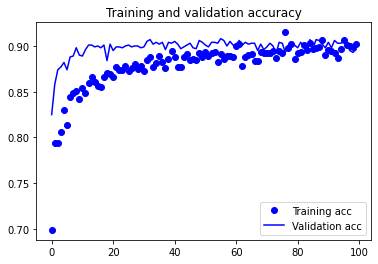

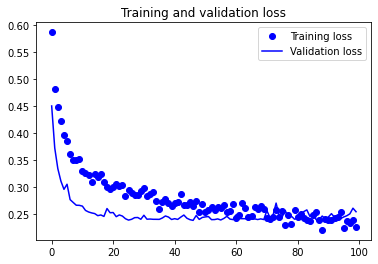

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#### 2.4.3 Pokrenite treniranje mreze sa istim parametrima kao sto je dato u sekciji 2.2.1. Objasnite rezultate.

- Batch size je isti tj `20`, optimizator ima vrijednost `lr=2e-5`, a broj epoha je stavljen na `30`.
- Kod je dat ispod, prikazani su grafici ispod.
- Vidimo da je postignuta tacnost oko `96.7%`, sto je dosta bolje nego u prosloj vjezbi. Takodjer na grafovima se moze primijetiti da nema overfitting-a s obzirom da validacijske krive i grafik treniranja se poklapaju.

In [ ]:
first_timestamp = time.time()

history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=30, validation_data=validation_generator, validation_steps=50)

second_timestamp = time.time()

training_time = second_timestamp - first_timestamp

print(*['Treniranje traje:', training_time, 'sekundi.'])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
100/100 [==============================] - 21s 211ms/step - loss: 0.2220 - acc: 0.9140 - val_loss: 0.2474 - val_acc: 0.9050
Epoch 2/30
100/100 [==============================] - 21s 208ms/step - loss: 0.2304 - acc: 0.9070 - val_loss: 0.2484 - val_acc: 0.9000
Epoch 3/30
100/100 [==============================] - 21s 210ms/step - loss: 0.2403 - acc: 0.8975 - val_loss: 0.2440 - val_acc: 0.9050
Epoch 4/30
100/100 [==============================] - 21s 210ms/step - loss: 0.2216 - acc: 0.9075 - val_loss: 0.2475 - val_acc: 0.9070
Epoch 5/30
100/100 [==============================] - 21s 211ms/step - loss: 0.2393 - acc: 0.8985 - val_loss: 0.2473 - val_acc: 0.9030
Epoch 6/30
100/100 [==============================] - 21s 210ms/step - loss: 0.2276 - acc: 0.8990 - val_loss: 0.2453 - val_acc: 0.9040
Epoch 7/30
100/100 [==============================] - 21s 215ms/step - loss: 0.2408 - acc: 0.8945 - val_loss: 0.2433 - val_acc: 0.8980
Epoch 8/30
100/100 [==============================] - 2

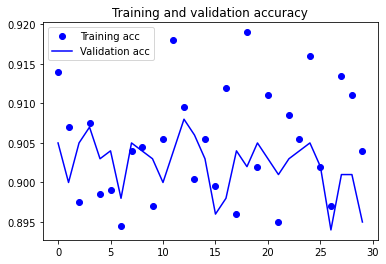

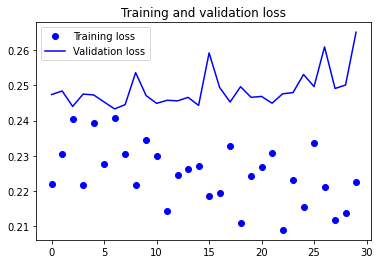

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## 3. Fino podesavanje ili Fine-tuning

#### 3.1 Na osnovu svih uputa definisite model u novoj datoteci.

In [40]:
% tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras import layers
import os 

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])

# training

first_timestamp = time.time()

history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=100, validation_data=validation_generator, validation_steps=50)

second_timestamp = time.time()

training_time = second_timestamp - first_timestamp

print(*['Treniranje traje:', training_time, 'sekundi.'])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
100/100 [==============================] - 23s 221ms/step - loss: 0.5685 - acc: 0.6865 - val_loss: 0.2697 - val_acc: 0.8910
Epoch 2/100
100/100 [==============================] - 22s 218ms/step - loss: 0.3541 - acc: 0.8438 - val_loss: 0.2265 - val_acc: 0.9000
Epoch 3/100
100/100 [==============================] - 22s 220ms/step - loss: 0.3078 - acc: 0.8622 - val_loss: 0.2199 - val_acc: 0.9130
Epoch 4/100
100/100 [==============================] - 22s 223ms/step - loss: 0.2583 - acc: 0.8952 - val_loss: 0.1886 - val_acc: 0.9140
Epoch 5/100
100/100 [==============================] - 22s 222ms/step - loss: 0.2559 - acc: 0.8943 - val_loss: 0.1859 - val_acc: 0.9250
Epoch 6/100
100/100 [==============================] - 22s 221ms/step - loss: 0.2245 - acc: 0.9045 - val_loss: 0.2044 - val_acc: 0.9170
Epoch 7/100
100/100 [==============================] - 22s 223ms/step - loss: 0.2473 - acc: 0.8944 - val_loss: 0.1721 - val_acc: 0.9260
Epoch 8/100
100/100 [===========================

#### 3.2 Dodajte kod za crtanje grafika tacnosti i funkcije gubitka. Pokrenite treniranje modela. Koliko treniranje traje? Nacrtajte tacnost i funkciju gubitka. Napravite zakljucke na osnovu rezultata.

- Vidimo da u slucaju kada se koristi fino podesavanje parametara, dobijamo vecu tacnost i bolje rezultate, u odnosu na slucaj kada ne koristimo fino podesavanje.

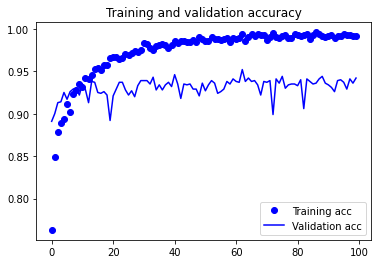

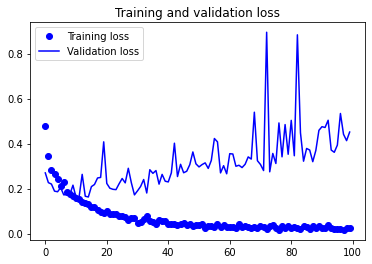

In [42]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#### 3.3 Koja metoda/tehnika daje najbolje rezultate (donesite zakljucak na osnovu sadrzaja cijele vjezbe)?

- Kod malih dataseto-va najveci je problem pojava overfitting-a, kao sto je vidjeno na graficima.
- Najbolji rezultat daje zadnji model koji ima oko `94%` tacnosti odnosno model sa finim podesavanjem parametara, takodjer isti ima mogucnost napredovanja po pitanju vece tacnosti.